# Hierarchical modeling

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Relation-between-casual-rides-and-total-counts" data-toc-modified-id="Relation-between-casual-rides-and-total-counts-2">Relation between casual rides and total counts</a></span><ul class="toc-item"><li><span><a href="#Resolved-by-hour" data-toc-modified-id="Resolved-by-hour-2.1">Resolved by hour</a></span></li></ul></li><li><span><a href="#Beta-binomial-algebraically" data-toc-modified-id="Beta-binomial-algebraically-3">Beta-binomial algebraically</a></span></li><li><span><a href="#Beta-binomial-with-pymc3" data-toc-modified-id="Beta-binomial-with-pymc3-4">Beta-binomial with pymc3</a></span></li><li><span><a href="#Hierarchical-models" data-toc-modified-id="Hierarchical-models-5">Hierarchical models</a></span></li><li><span><a href="#More-hierarchies" data-toc-modified-id="More-hierarchies-6">More hierarchies</a></span></li><li><span><a href="#Resources" data-toc-modified-id="Resources-7">Resources</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az

## Load the data

In [3]:
df = pd.read_csv(
    '../../../dataset-collection/Bike-Sharing-Dataset/hour.csv')
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Relation between casual rides and total counts

In [4]:
df['casual_pct'] = df['casual']/df['cnt']

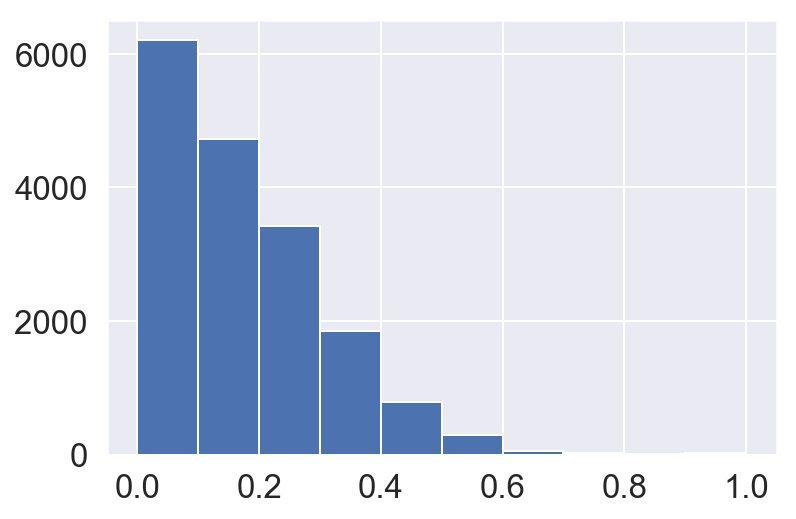

In [5]:
df['casual_pct'].hist();

In [6]:
df['casual_pct'].describe()

count    17379.000000
mean         0.172143
std          0.136557
min          0.000000
25%          0.063492
50%          0.146893
75%          0.253731
max          1.000000
Name: casual_pct, dtype: float64

### Resolved by hour

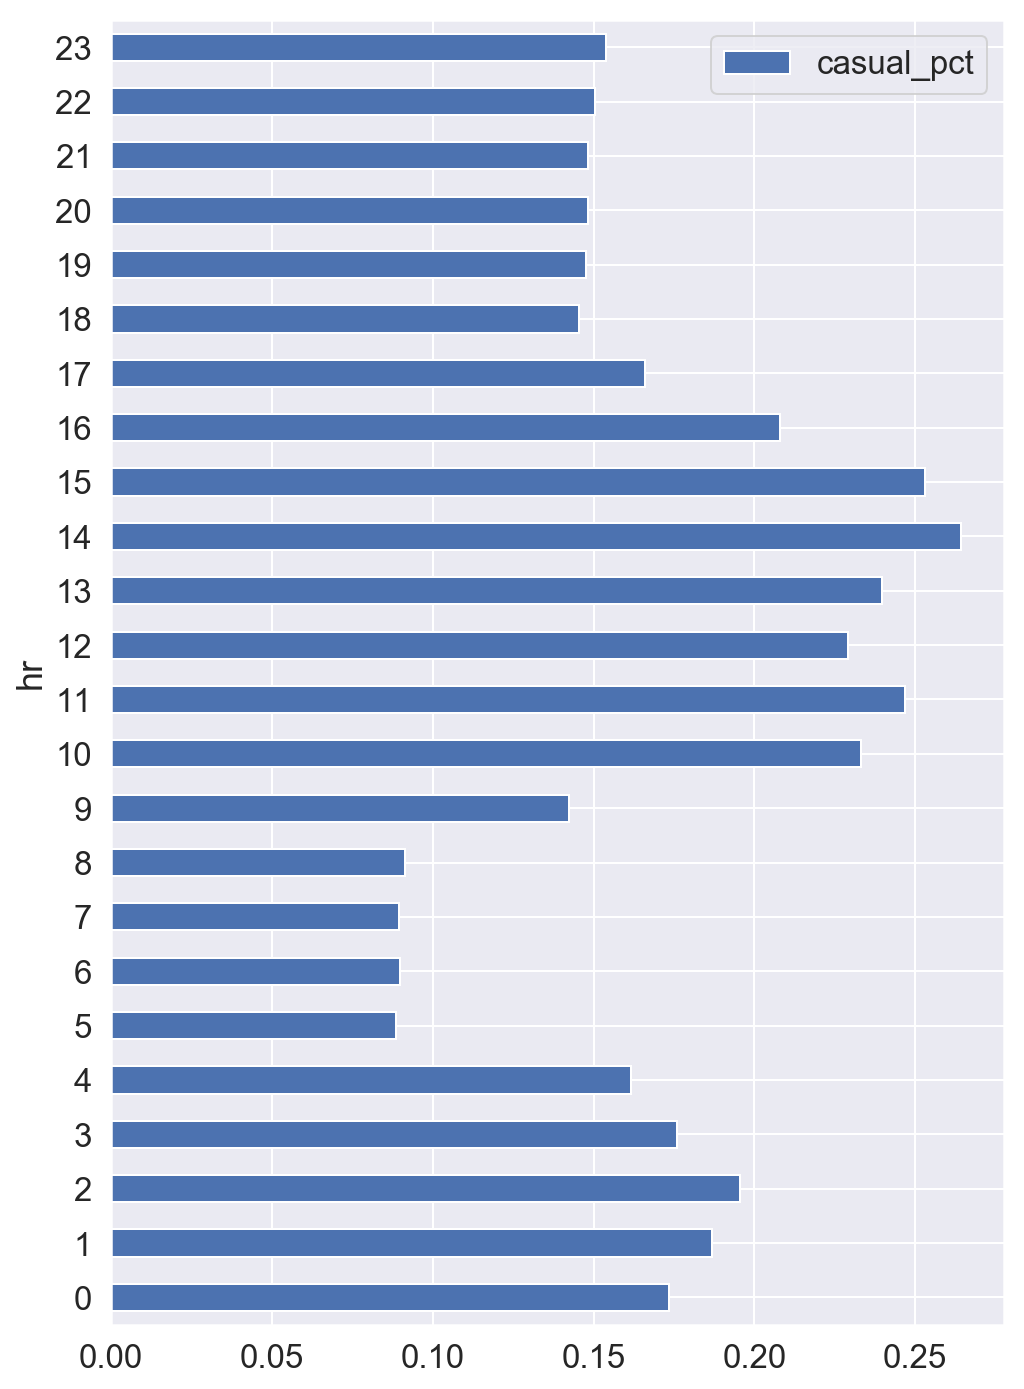

In [7]:
grouped = df.groupby('hr')[['casual_pct']]
grouped.mean().plot(kind='barh',figsize=(8,12));

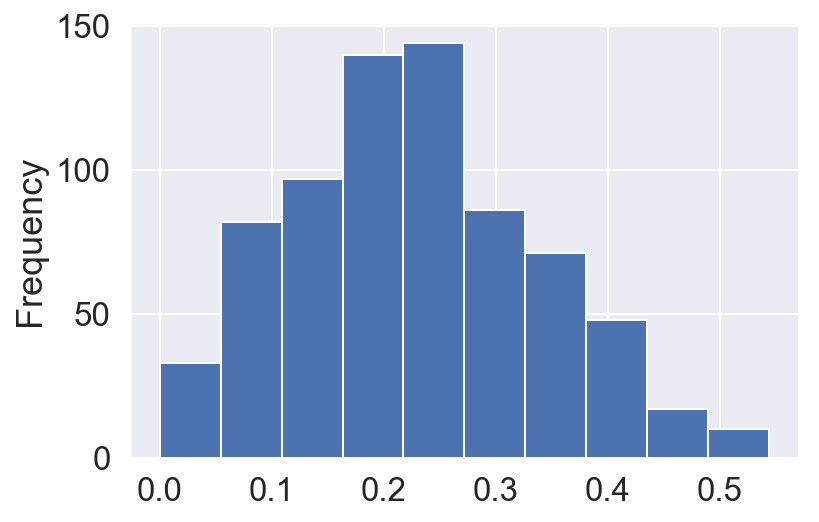

In [8]:
df[df.hr==12].casual_pct.plot(kind='hist');

## Beta-binomial algebraically

In [9]:
df[['casual','registered']].iloc[:3]

casual  registered
0       3          13
1       8          32
2       5          27

In [10]:
from scipy import stats

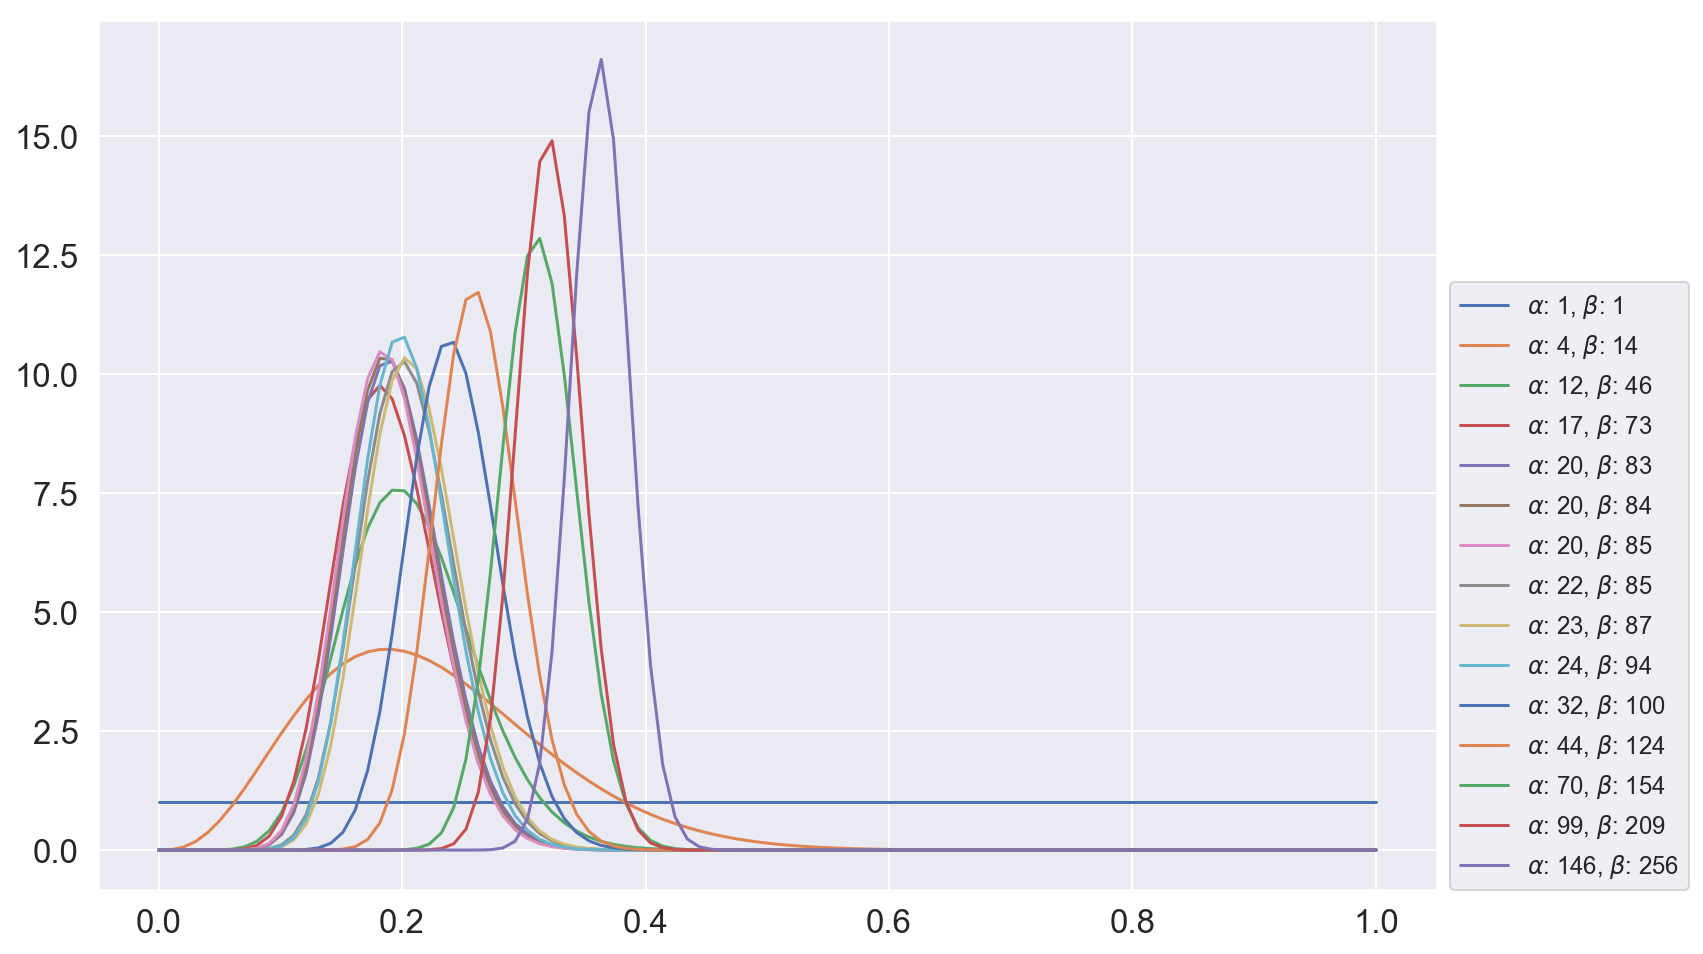

In [11]:
alpha = 1
beta = 1
xvals = np.linspace(0,1,100)

fig, ax = plt.subplots(figsize=(12,8))
for i in range(30):
    beta_dist = stats.beta(alpha,beta)
    yvals = beta_dist.pdf(xvals)
    if i < 15:
        ax.plot(xvals,yvals,label=r'$\alpha$: {}, $\beta$: {}'.format(alpha,beta))
    alpha += df.casual[i]
    beta += df.registered[i]
ax.legend(loc=[1.01,0],fontsize=12)
plt.show()

## Beta-binomial with pymc3

In [12]:
sample = df[:100][['casual','cnt']]

In [13]:
sample_ratio = sample.sum()[0]/sample.sum()[1]
sample_ratio

0.1379173290937997

In [14]:
alpha = 5
beta = 3
with pm.Model() as model:
    theta = pm.Beta('p',alpha,beta)
    likelihood = pm.Binomial('likelihood',n=sample.sum()[1],p=theta, observed=sample.sum()[0])     

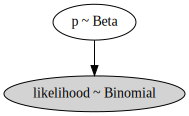

In [15]:
pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(draws=500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1963.62draws/s]


In [17]:
pm.summary(trace)

mean       sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
p  0.138662  0.00498  0.000245  0.128279  0.148231  348.351848  0.999104

## Hierarchical models

Bayesian models allows us to construct models which involve many parameters. We want to obtain  the posterior from the prior and the likelihood. The latter describes the data conditioned on all the model parameters:

$$p(\theta,\omega|D) \propto p(D|\theta,\omega)p(\theta,\omega)
$$

Often we have the situation that the likelihood does not directly depend on all the model parameters, but only indirectly through its parameters:

$$
\begin{eqnarray*}
p(\theta,\omega|D) &\propto&p(D|\theta,\omega)p(\theta,\omega)\\
&=&p(D|\theta)p(\theta,\omega)\\
&=&p(D|\theta)p(\theta|\omega)p(\omega)
\end{eqnarray*}
$$

This situation often arises when we set prior distributions which have their own shape parameters, but also when we have data in categories and subcategories.

For example here we can resolve the casual and total counts per hour. Naturally we would believe that the proportions vary over the hours. But we could make the individual group statistics depend on the statistics of the larger group - this procedure is in particular useful if we have varying amounts of observations per group. Hierarchical models help to adjust to larger patterns without having to give up the finer structure.

We will see that depending on how much data we have, the priors which are informed about larger group means will have more or less influence on each group estimate.

In [18]:
grouped = df[:36].groupby('hr')[['casual','registered','cnt']]

In [19]:
grouped.sum()

casual  registered  cnt
hr                         
0        7          26   33
1        9          48   57
2        6          35   41
3        5          14   19
4        2           2    4
5        0           1    1
6        2           2    4
7        1           3    4
8        1          15   16
9        9          25   34
10      19          70   89
11      42          84  126
12      49         128  177
13      47          47   94
14      35          71  106
15      40          70  110
16      41          52   93
17      15          52   67
18       9          26   35
19       6          31   37
20      11          25   36
21       3          31   34
22      11          17   28
23      15          24   39

These are the proportions of casual to registered rides per group.

In [20]:
overall_ratio = (df.sum().casual/df.sum().registered)
overall_ratio

0.23198481513936292

In [21]:
group_ratios = (grouped.sum().casual/grouped.sum().registered)

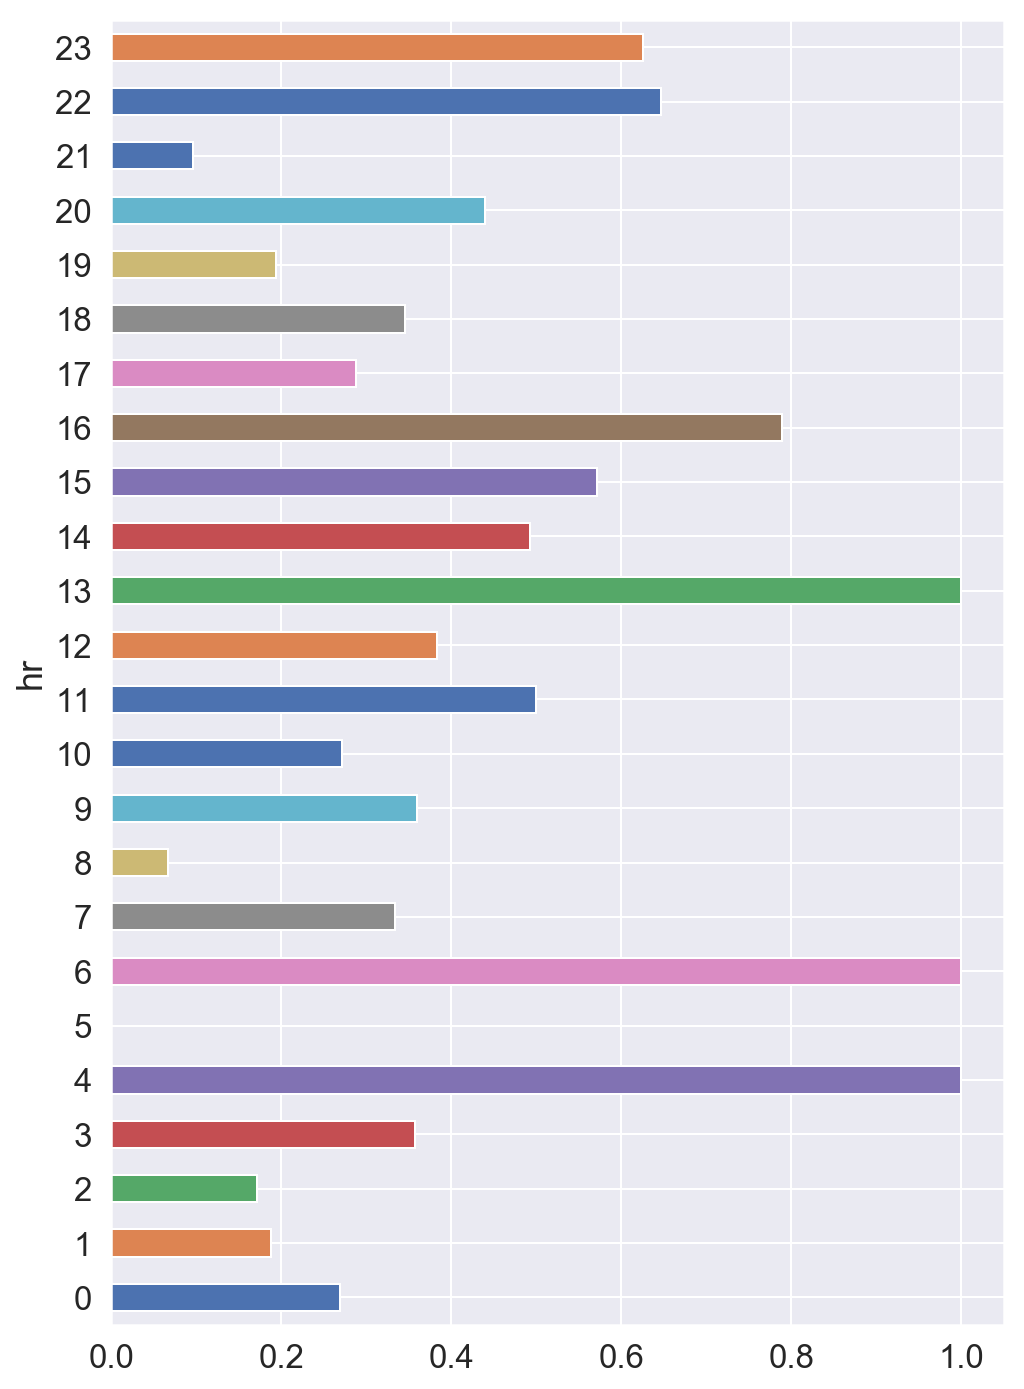

In [22]:
group_ratios.plot(kind='barh',figsize=(8,12))
plt.show()

In [23]:
casual = grouped.sum().casual
total = grouped.sum().cnt
registered = grouped.sum().registered

In [24]:
casual.values

array([ 7,  9,  6,  5,  2,  0,  2,  1,  1,  9, 19, 42, 49, 47, 35, 40, 41,
       15,  9,  6, 11,  3, 11, 15])

Our model will basically be a beta-binomial model for each of the groups. However we do not set the shape parameters of the beta-prior directly, but we will model them through their own distributions. To do so, we follow a setup for example suggested by [John Kruschke](#Kruschke).

We are not going to model the parameters of the prior ($\alpha$ and $\beta$, but rather parameters describing the mode and concentration (not the standard deviation, but related to the spread) of the beta distribution:

$$
\begin{eqnarray*}
\alpha &=& \omega(\kappa-2)+1 \\
\beta &=& (1-\omega)(\kappa-2)+1
\end{eqnarray*}
$$

Reverting the relationship we could also write
$$
\begin{eqnarray*}
\omega &=& \frac{\alpha-1}{\alpha+\beta-2} \\
\kappa &=& \alpha+\beta
\end{eqnarray*}
$$

The parameter $\omega$ we are going to model through another beta distribution whose shape parameters we are going to set by the total number of casual and registered rides irrespective of each group - in this way we inform about the group level higher in the hierarchy.

The parameter $\kappa$ we are modeling through a Gamma-distribution (which covers the whole real line), however certifying that each distribution covers only the appropriate range (in particular certifying $\kappa<2$ by shifting the Gamma-distribution). About this parameter we have less of a feeling about its appropriate value. Therefore we choose a very uninformed type of Gamma-prior.

We illustrate how this prior looks like through the following.

In [25]:
with pm.Model() as prior_dist:
    omega = pm.Beta('omega', alpha=df.casual.sum(), beta=df.registered.sum())
    kappa_minus2 = pm.Gamma('kappa_minus2', alpha=0.01, beta=0.01)
    trace_prior = pm.sample(5000,step=pm.Slice(),tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [kappa_minus2]
>Slice: [omega]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:05<00:00, 2355.83draws/s]


In [26]:
prior_dist

In [27]:
pm.summary(trace_prior)

mean        sd  mc_error        hpd_2.5  hpd_97.5  \
omega         0.188304  0.000217  0.000002   1.878880e-01  0.188741   
kappa_minus2  0.979324  9.051802  0.088342  2.163914e-302  0.342567   

                     n_eff      Rhat  
omega         10118.547292  0.999919  
kappa_minus2  10118.886003  0.999902

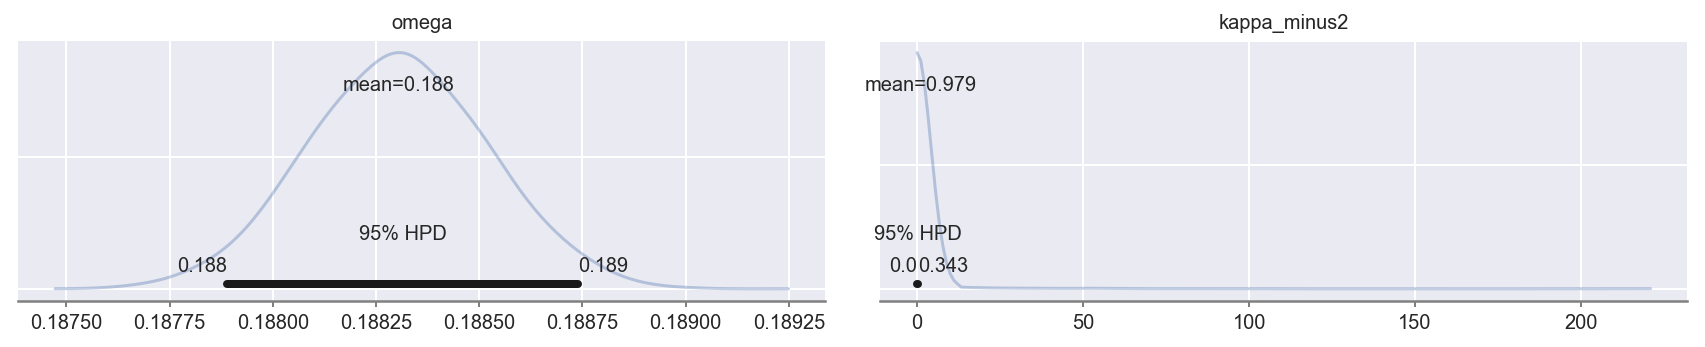

In [28]:
pm.plot_posterior(trace_prior,kde_plot=True);

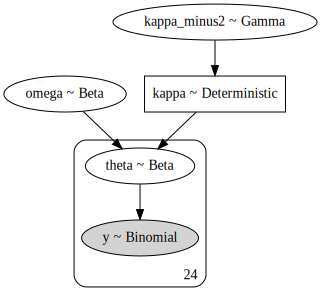

In [29]:
factor = 1

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 
                    alpha=factor*df.casual.sum(), 
                    beta=factor*df.registered.sum())
    kappa_minus2 = pm.Gamma('kappa_minus2', 
                            alpha=0.01, 
                            beta=0.01)
    kappa = pm.Deterministic('kappa', 
                             kappa_minus2 + 2)
    
    theta = pm.Beta('theta', 
                    alpha=omega*(kappa-2)+1, 
                    beta=(1-omega)*(kappa-2)+1, 
                    shape=24)
        
    y = pm.Binomial('y', 
                    n=total.values, 
                    p=theta, 
                    observed=casual.values
                    ) 
    
pm.model_to_graphviz(hierarchical_model)

In [30]:
with hierarchical_model:
    trace_h = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa_minus2, omega]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 370.42draws/s]


In [31]:
pm.summary(trace_h)

mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
omega          0.188303  0.000223  0.000004  0.187894   0.188767  4733.572559   
kappa_minus2  10.590565  4.449964  0.105382  3.407283  19.717741  1806.778796   
kappa         12.590565  4.449964  0.105382  5.407283  21.717741  1806.778796   
theta__0       0.218526  0.059732  0.000861  0.109220   0.339084  4587.943146   
theta__1       0.171926  0.046419  0.000583  0.087553   0.265294  5334.322451   
theta__2       0.167282  0.051103  0.000685  0.072214   0.263253  6217.260712   
theta__3       0.255877  0.078576  0.001183  0.100054   0.404853  4826.837232   
theta__4       0.310209  0.116406  0.002025  0.106262   0.538232  3374.351020   
theta__5       0.223881  0.112972  0.001974  0.024191   0.436695  3575.655607   
theta__6       0.309630  0.114226  0.002056  0.095704   0.530494  3201.092392   
theta__7       0.243972  0.105978  0.001716  0.055547   0.458406  4361.461241   
theta__8       0.139959  0.062869  0.000921  0.032290   0.263077  4240.245101   
theta__9       0.258415  0.064106  0.000929  0.138734   0.384005  7631.429265   
theta__10      0.216463  0.040499  0.000521  0.136705   0.297162  6308.342338   
theta__11      0.325052  0.038985  0.000632  0.259173   0.407384  4159.236650   
theta__12      0.274705  0.032201  0.000489  0.212396   0.335606  4331.655290   
theta__13      0.469927  0.050539  0.000754  0.377487   0.571649  4654.485324   
theta__14      0.319263  0.042787  0.000630  0.234788   0.401196  4879.619064   
theta__15      0.351540  0.044558  0.000645  0.274359   0.443120  4692.145196   
theta__16      0.417556  0.049983  0.000750  0.315413   0.511843  3428.830798   
theta__17      0.225601  0.046927  0.000734  0.138658   0.317501  4149.265981   
theta__18      0.251406  0.062897  0.000795  0.132641   0.378181  4783.498021   
theta__19      0.181220  0.055425  0.000828  0.075504   0.282429  3958.295679   
theta__20      0.288778  0.064840  0.001083  0.169918   0.419077  4002.330368   
theta__21      0.128917  0.049703  0.000735  0.042134   0.228233  4142.390455   
theta__22      0.346646  0.074784  0.000956  0.196373   0.487030  5454.417127   
theta__23      0.349364  0.066688  0.000975  0.227372   0.480030  5012.164520   

                  Rhat  
omega         1.000015  
kappa_minus2  1.001090  
kappa         1.001090  
theta__0      0.999507  
theta__1      0.999568  
theta__2      0.999535  
theta__3      0.999834  
theta__4      0.999606  
theta__5      0.999654  
theta__6      1.000103  
theta__7      0.999512  
theta__8      0.999659  
theta__9      0.999500  
theta__10     0.999550  
theta__11     0.999500  
theta__12     1.000509  
theta__13     0.999696  
theta__14     1.000311  
theta__15     0.999597  
theta__16     1.000209  
theta__17     0.999517  
theta__18     1.000433  
theta__19     0.999700  
theta__20     0.999662  
theta__21     0.999500  
theta__22     0.999502  
theta__23     0.999649

In [32]:
group_model = pd.DataFrame([group_ratios.values,trace_h['theta'].mean(axis=0)],index=['group','model'])
group_model

0         1         2         3         4         5        6   \
group  0.269231  0.187500  0.171429  0.357143  1.000000  0.000000  1.00000   
model  0.218526  0.171926  0.167282  0.255877  0.310209  0.223881  0.30963   

             7         8         9     ...           14        15        16  \
group  0.333333  0.066667  0.360000    ...     0.492958  0.571429  0.788462   
model  0.243972  0.139959  0.258415    ...     0.319263  0.351540  0.417556   

             17        18        19        20        21        22        23  
group  0.288462  0.346154  0.193548  0.440000  0.096774  0.647059  0.625000  
model  0.225601  0.251406  0.181220  0.288778  0.128917  0.346646  0.349364  

[2 rows x 24 columns]

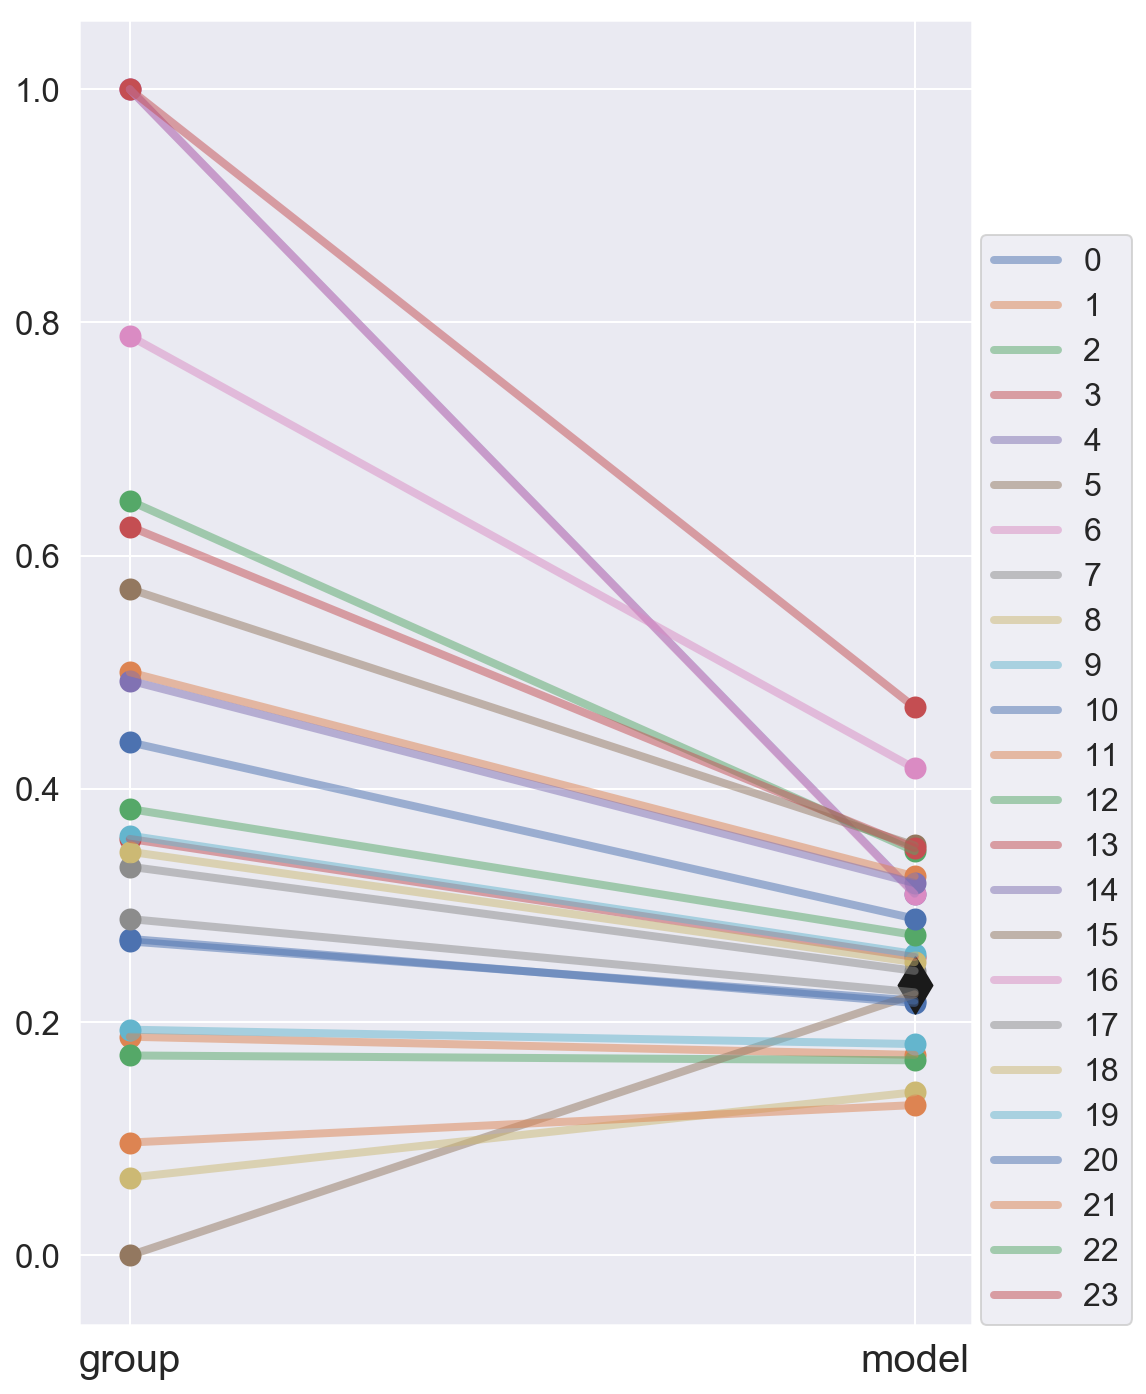

In [33]:
fig, ax = plt.subplots(figsize=(8,12))
group_model.plot(lw=4, ax=ax, alpha=0.5)
for col in group_model.columns:
    ax.scatter([0,1],group_model[col].values,s=100)
ax.scatter([1],[overall_ratio],marker='d', s=400, color='k')
ax.legend(loc=[1.01,0],fontsize=16)
plt.xticks([0,1],['group','model'],fontsize=20)
plt.show()

Differences between groups and model:

In [34]:
np.around((grouped.sum().casual/grouped.sum().cnt).values-trace_h['theta'].mean(axis=0),5)

array([-0.00641, -0.01403, -0.02094,  0.00728,  0.18979, -0.22388,
        0.19037,  0.00603, -0.07746,  0.00629, -0.00298,  0.00828,
        0.00213,  0.03007,  0.01093,  0.0121 ,  0.0233 , -0.00172,
        0.00574, -0.01906,  0.01678, -0.04068,  0.04621,  0.03525])

In [35]:
rope_boundaries = overall_ratio+0.01*np.array([-1,1])

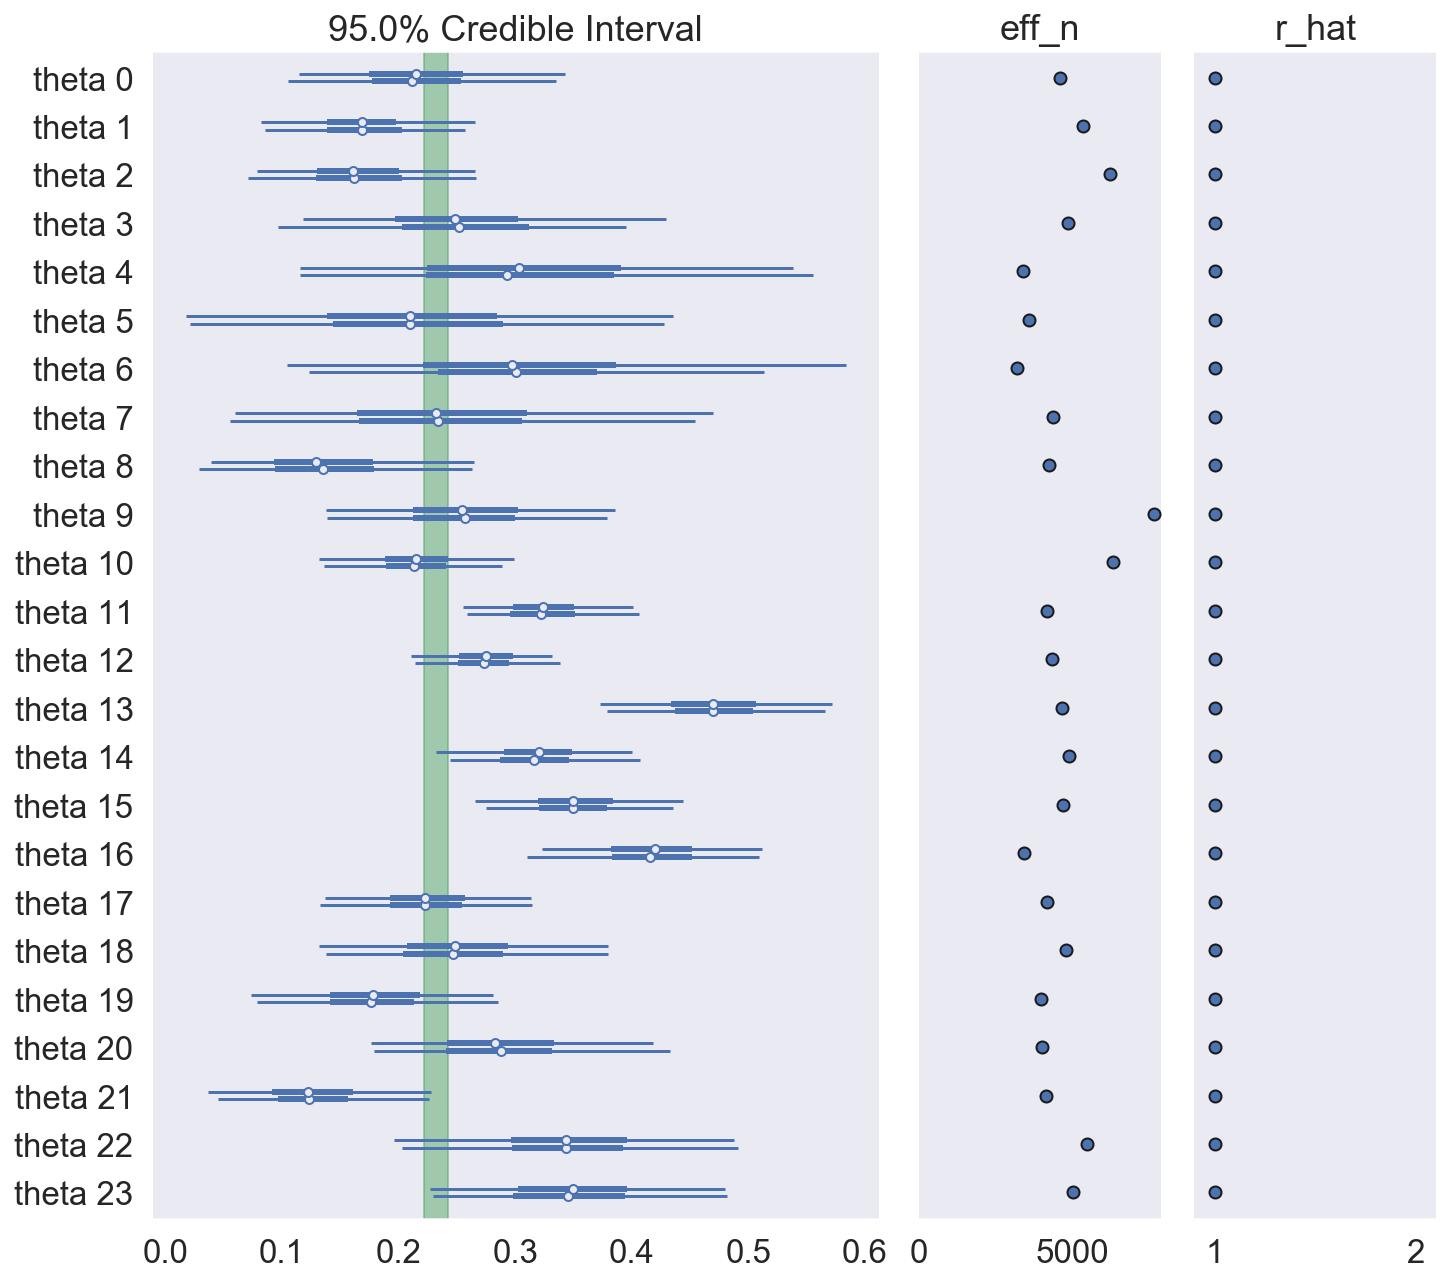

In [36]:
az.plot_forest(trace_h, var_names=['theta'], rope=rope_boundaries, eff_n=True, r_hat=True, credible_interval=0.95)
plt.show()

## More hierarchies


- Group additionally by working day
- Take workingday/weekend as an additional hierarchy level
- Take at least as many data points as required to have entries for all 48 lowest hierarchy levels
- Add an intermediate level for theta parameters informed about the overall theta and feeding down to the individual entries
- No need to add an additional level for the kappa parameter 

In [37]:
df.workingday.value_counts(normalize=True)

1    0.682721
0    0.317279
Name: workingday, dtype: float64

## Resources

<a name='Kruschke'></a> J. K. Kruschke: Doing Bayesian Data Analysis (2nd edition), Academic Press, 2015, chapter 9